# Recognizing UVA landmarks with neural nets (100 pts)

## Robert Clay Harris: jbm2rt

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country.

In this assignment, you will attempt the build image recognition systems to classify different buildlings/landmarks on Grounds. You will implement various CNN architectures covered in
Chapters 7-8, including VGG blocks, Network-in-Network (NiN) with GAP,
Inception modules, and ResNet blocks. You'll also explore transfer learning
with pretrained models.

Total Points: 100 + 5 bonus points
- Part 1: Implement VGG-style blocks (15 pts)
- Part 2: Implement NiN with Global Average Pooling (15 pts)
- Part 3: Implement Inception modules (15 pts)
- Part 4: Implement ResNet blocks (15 pts)
- Part 5: Transfer Learning with Pretrained Models (20 pts)
- Part 6: Efficient Architectures (20 pts)
- Bonus: Achieve >94% accuracy on the test set (5 pts)


Dataset: UVA Landmarks with 18 classes

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb and pdf files via UVA Canvas with the following format: yourcomputingID_assignment_2.*

Best of luck, and have fun!

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in a Firebase server. This dataset will be the one you will benchmark for your grade.

In [10]:
"""
Dataset: UVA Landmarks with 18 classes
Submission: yourcomputingID_assignment_2.ipynb and pdf

IMPORTANT DESIGN PRINCIPLES:
1. Use BatchNorm after every Conv layer (before activation)
2. Use ReLU activation (inplace=True saves memory)
3. Use bias=False in Conv when followed by BatchNorm
4. Initialize weights properly for better convergence
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import urllib.request
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# Data Loading and Preprocessing
# ============================================================================

def download_dataset():
    """Download and extract the UVA landmarks dataset."""
    url = "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

    if not os.path.exists('dataset'):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, 'dataset.zip')
        print("Extracting dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('dataset.zip')
    else:
        print("Dataset already exists.")

# Download dataset
download_dataset()

# Dataset parameters
data_dir = "dataset/"
batch_size = 32
img_height = 150
img_width = 150
num_classes = 18

# Class names for UVA landmarks
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
               'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall',
               'NewCabellHall', 'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall',
               'Rotunda', 'ScottStadium', 'ThorntonHall', 'UniversityChapel']

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Using device: cuda
Dataset already exists.
Training samples: 11428
Validation samples: 2858


In [11]:
# ============================================================================
# Part 1: VGG-Style Blocks (15 points)
# ============================================================================

class VGGBlock(nn.Module):
    """
    VGG-style block:
      - num_convs times: Conv(3x3, bias=False) -> BN -> ReLU
      - then MaxPool2d(2, 2)
    """
    def __init__(self, in_channels, out_channels, num_convs=2):
        super(VGGBlock, self).__init__()
        layers = []
        c_in = in_channels
        for _ in range(num_convs):
            layers += [
                nn.Conv2d(c_in, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            c_in = out_channels
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class VGGNet(nn.Module):
    """
    Simplified VGG:
      stem: 3 -> 64 (Conv-BN-ReLU)
      blocks: 64->128, 128->256 (each halving spatial size)
      GAP -> Linear(256 -> num_classes)
    """
    def __init__(self, num_classes=18):
        super(VGGNet, self).__init__()
        stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        block1 = VGGBlock(64, 128, num_convs=2)
        block2 = VGGBlock(128, 256, num_convs=2)

        # feature extractor
        self.features = nn.Sequential(stem, block1, block2)

        # global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)            # conv features
        x = self.avgpool(x)             # (B, 256, 1, 1)
        x = torch.flatten(x, 1)         # (B, 256)
        x = self.classifier(x)          # logits
        return x

In [12]:
# ============================================================================
# Part 2: Network in Network (NiN) with GAP (15 points)
# ============================================================================

class NiNBlock(nn.Module):
    """
    NiN block:
      spatial conv (k=kernel_size, stride, padding)
      -> 1x1 conv
      -> 1x1 conv
    Each conv: Conv (bias=False) -> BN -> ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(NiNBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                      stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_block(x)


class NiN(nn.Module):
    """
    Network-in-Network with GAP:
      NiN(3->96, k=11, s=4) -> MaxPool(3,2)
      NiN(96->256, k=5, p=2) -> MaxPool(3,2)
      NiN(256->384, k=3, p=1) -> MaxPool(3,2)
      NiN(384->num_classes, k=3, p=1)
      GAP -> logits (no FC needed)
    """
    def __init__(self, num_classes=18):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            NiNBlock(3, 96, kernel_size=11, stride=4, padding=0),
            nn.MaxPool2d(kernel_size=3, stride=2),

            NiNBlock(96, 256, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            NiNBlock(256, 384, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            NiNBlock(384, num_classes, kernel_size=3, stride=1, padding=1),

            nn.AdaptiveAvgPool2d((1, 1)),  # GAP to 1x1
        )

    def forward(self, x):
        x = self.features(x)     # (B, num_classes, 1, 1)
        x = torch.flatten(x, 1)  # (B, num_classes)
        return x

In [13]:
# ============================================================================
# Part 3: Inception Module (15 points)
# ============================================================================

class InceptionBlock(nn.Module):
    """
    Inception block with 4 parallel branches:
      1) 1x1
      2) 1x1 -> 3x3
      3) 1x1 -> 5x5
      4) 3x3 maxpool -> 1x1
    Each conv: Conv(bias=False) -> BN -> ReLU
    """
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(InceptionBlock, self).__init__()

        # Branch 1: 1x1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1, bias=False),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True),
        )

        # Branch 2: 1x1 -> 3x3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1, bias=False),
            nn.BatchNorm2d(ch3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True),
        )

        # Branch 3: 1x1 -> 5x5
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1, bias=False),
            nn.BatchNorm2d(ch5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True),
        )

        # Branch 4: 3x3 maxpool (s=1, p=1) -> 1x1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1, bias=False),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], dim=1)


class SimpleGoogLeNet(nn.Module):
    """
    Simplified GoogLeNet with Inception modules.
    """
    def __init__(self, num_classes=18):
        super(SimpleGoogLeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Inception3a: input=64, output=256 (64+128+32+32)
        self.inception3a = InceptionBlock(64, 64, 96, 128, 16, 32, 32)
        # Inception3b: input=256, output=480 (128+192+96+64)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [14]:
# ============================================================================
# Part 4: ResNet Blocks (15 points)
# ============================================================================

class BasicBlock(nn.Module):
    """
    Basic ResNet block:
      Main: 3x3(s=stride) -> BN -> ReLU -> 3x3 -> BN
      Skip: Identity or 1x1(s=stride) -> BN (when shape changes)
      Out:  Add -> ReLU
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # skip path (projection if shape changes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = out + self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    """
    ResNet-18:
      conv1 (7x7,s=2) -> maxpool
      layer1: 2x(64)
      layer2: 2x(128), downsample
      layer3: 2x(256), downsample
      layer4: 2x(512), downsample
      GAP -> FC
    """
    def __init__(self, num_classes=18):
        super(ResNet18, self).__init__()
        # stem
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # residual stages
        self.layer1 = self._make_layer(64, 64,  num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        # head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        # first block may downsample / change channels
        blocks = [BasicBlock(in_channels, out_channels, stride=stride)]
        # remaining blocks keep same channels, stride=1
        for _ in range(1, num_blocks):
            blocks.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)   # 1/4 size
        x = self.layer2(x)   # 1/8
        x = self.layer3(x)   # 1/16
        x = self.layer4(x)   # 1/32
        x = self.avgpool(x)  # (B, 512, 1, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [15]:
# ============================================================================
# Part 5: Transfer Learning (20 points)
# ============================================================================

def get_pretrained_model(model_name='resnet18', num_classes=18, feature_extract=True):
    """
    Return a pretrained model with its final classifier replaced for `num_classes`.
    If `feature_extract` is True, freeze all feature parameters.
    Supported: 'resnet18', 'vgg16', 'mobilenet_v2'
    """
    name = model_name.lower()

    if name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        if feature_extract:
            for p in model.parameters():
                p.requires_grad = False
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
        return model

    elif name == 'vgg16':
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        if feature_extract:
            for p in model.features.parameters():  # freeze conv backbone
                p.requires_grad = False
        # replace last linear layer
        in_feats = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_feats, num_classes)
        return model

    elif name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        if feature_extract:
            for p in model.parameters():
                p.requires_grad = False
        # replace last linear layer in classifier
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)
        return model

    else:
        raise ValueError(f"Unsupported model_name '{model_name}'. "
                         "Choose from: 'resnet18', 'vgg16', 'mobilenet_v2'.")

In [16]:
# ============================================================================
# Training and Evaluation Functions (Provided - No modifications needed)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        scheduler.step()

    return history


def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Testing your CNN implementations on UVA Landmarks Dataset

Part 1: Testing VGGNet
VGGNet Parameters: 1,113,938

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:02<00:00, 36.06it/s]


Train Loss: 2.2029, Train Acc: 32.75%
Val Loss: 1.8801, Val Acc: 43.18%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:02<00:00, 35.74it/s]


Train Loss: 1.6669, Train Acc: 50.95%
Val Loss: 1.7574, Val Acc: 45.66%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s]


Train Loss: 1.3599, Train Acc: 61.21%
Val Loss: 1.4215, Val Acc: 57.59%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:02<00:00, 35.80it/s]


Train Loss: 1.1630, Train Acc: 66.99%
Val Loss: 1.5776, Val Acc: 56.33%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s]


Train Loss: 0.9964, Train Acc: 71.87%
Val Loss: 1.1754, Val Acc: 65.05%


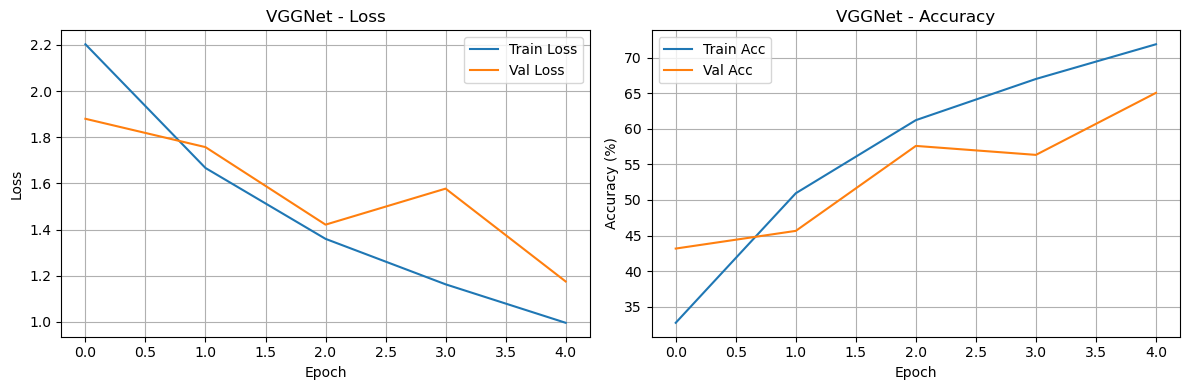


Part 2: Testing Network in Network
NiN Parameters: 2,045,780

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 90.14it/s] 


Train Loss: 2.3571, Train Acc: 32.58%
Val Loss: 2.2119, Val Acc: 36.56%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 91.64it/s] 


Train Loss: 1.7328, Train Acc: 54.00%
Val Loss: 1.5815, Val Acc: 55.56%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 91.10it/s] 


Train Loss: 1.3666, Train Acc: 64.44%
Val Loss: 1.2779, Val Acc: 64.56%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 95.18it/s] 


Train Loss: 1.1231, Train Acc: 71.39%
Val Loss: 1.2148, Val Acc: 66.69%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 95.65it/s] 


Train Loss: 0.9486, Train Acc: 76.01%
Val Loss: 1.0581, Val Acc: 70.33%


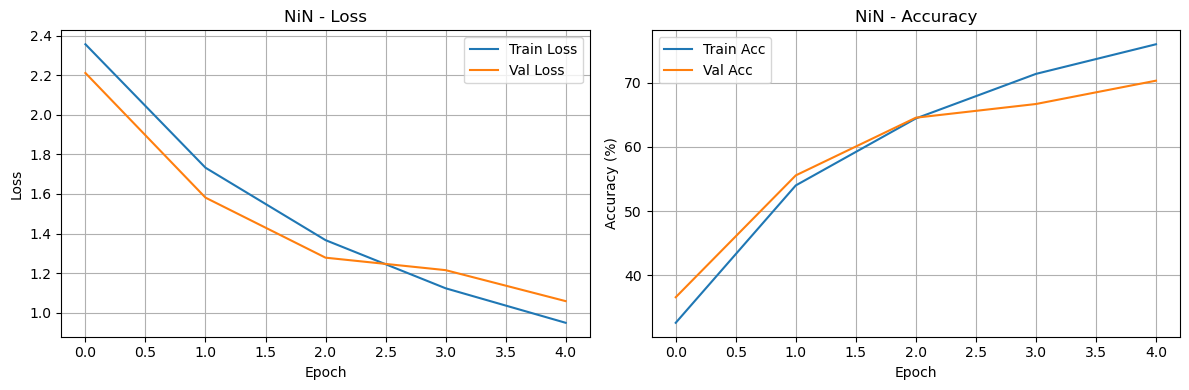


Part 3: Testing Inception Module
GoogLeNet Parameters: 545,010

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 86.92it/s] 


Train Loss: 2.0163, Train Acc: 39.60%
Val Loss: 1.8381, Val Acc: 45.10%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 86.62it/s] 


Train Loss: 1.4451, Train Acc: 58.02%
Val Loss: 1.4608, Val Acc: 56.02%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 88.01it/s] 


Train Loss: 1.1319, Train Acc: 67.70%
Val Loss: 1.3235, Val Acc: 60.01%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 79.06it/s]


Train Loss: 0.9542, Train Acc: 72.95%
Val Loss: 0.9761, Val Acc: 71.97%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 86.29it/s] 


Train Loss: 0.8279, Train Acc: 76.44%
Val Loss: 1.1074, Val Acc: 68.40%


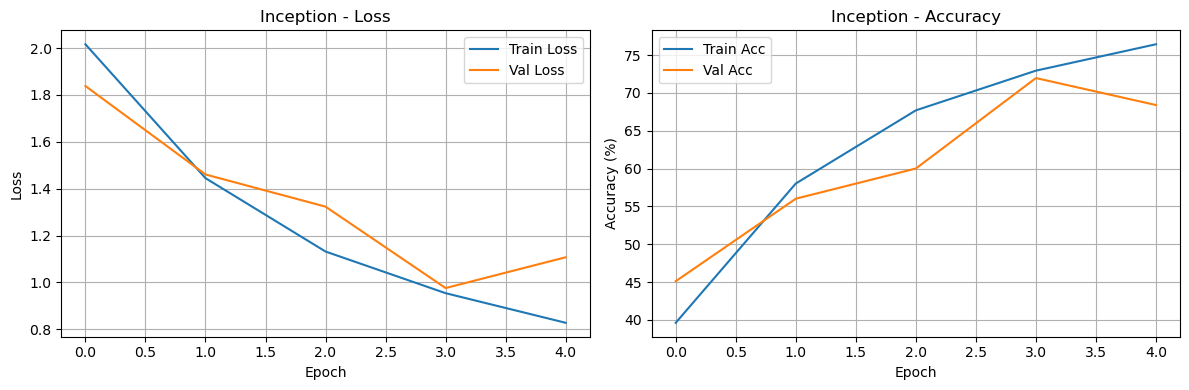


Part 4: Testing ResNet
ResNet18 Parameters: 11,185,746

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 87.52it/s] 


Train Loss: 2.2301, Train Acc: 32.09%
Val Loss: 1.8970, Val Acc: 41.22%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 90.41it/s] 


Train Loss: 1.4781, Train Acc: 55.53%
Val Loss: 1.8203, Val Acc: 46.96%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 90.42it/s] 


Train Loss: 1.0373, Train Acc: 68.96%
Val Loss: 1.2494, Val Acc: 64.73%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 87.27it/s] 


Train Loss: 0.7761, Train Acc: 76.94%
Val Loss: 0.8568, Val Acc: 74.88%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 91.29it/s] 


Train Loss: 0.5937, Train Acc: 82.68%
Val Loss: 0.8830, Val Acc: 75.61%


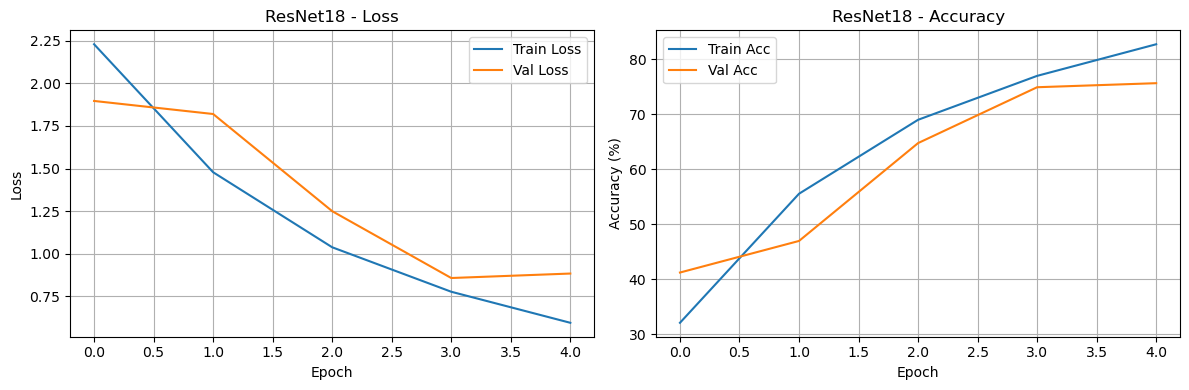


Part 5: Testing Transfer Learning

Testing Feature Extraction (frozen backbone)...

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 86.58it/s] 


Train Loss: 1.6543, Train Acc: 53.84%
Val Loss: 1.2139, Val Acc: 67.04%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 87.32it/s] 


Train Loss: 1.0778, Train Acc: 70.20%
Val Loss: 1.0508, Val Acc: 71.17%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 86.53it/s] 


Train Loss: 0.9327, Train Acc: 73.76%
Val Loss: 0.9679, Val Acc: 72.71%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 88.52it/s] 


Train Loss: 0.8587, Train Acc: 75.56%
Val Loss: 0.9536, Val Acc: 72.53%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 89.64it/s] 


Train Loss: 0.7975, Train Acc: 76.95%
Val Loss: 0.9006, Val Acc: 74.04%


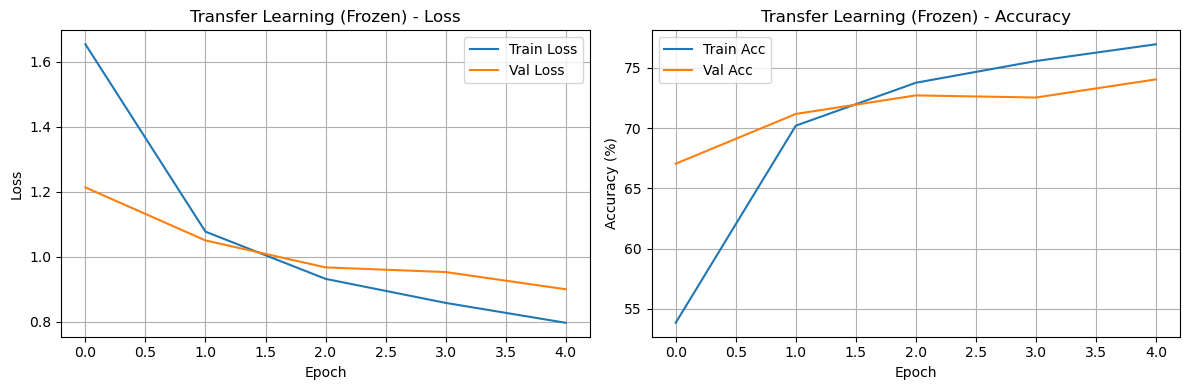


Testing Fine-tuning (trainable backbone)...

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 95.24it/s] 


Train Loss: 0.7195, Train Acc: 81.40%
Val Loss: 0.3049, Val Acc: 93.32%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 95.62it/s] 


Train Loss: 0.1276, Train Acc: 97.30%
Val Loss: 0.2495, Val Acc: 93.91%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:01<00:00, 87.90it/s] 


Train Loss: 0.0434, Train Acc: 99.18%
Val Loss: 0.2132, Val Acc: 95.17%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 94.27it/s] 


Train Loss: 0.0240, Train Acc: 99.59%
Val Loss: 0.2316, Val Acc: 94.86%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:00<00:00, 94.11it/s] 


Train Loss: 0.0137, Train Acc: 99.82%
Val Loss: 0.2348, Val Acc: 94.72%


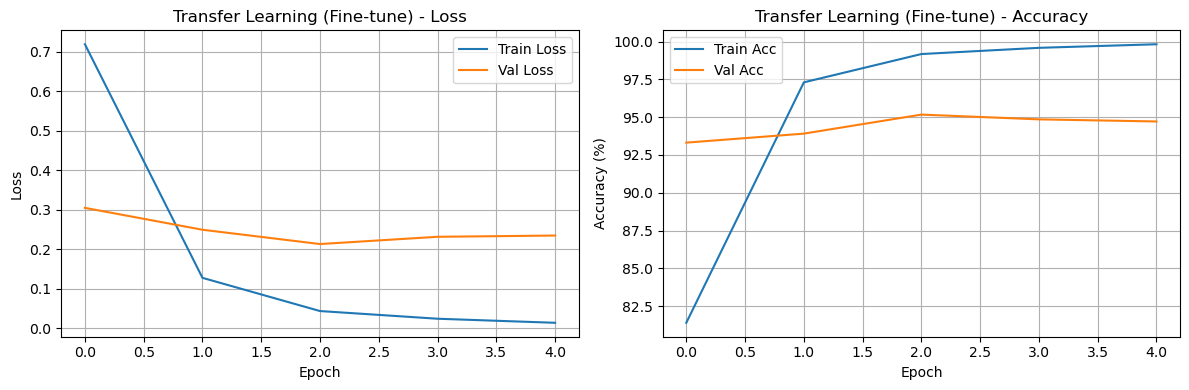


RESULTS SUMMARY
VGGNet              : 65.05%
NiN                 : 70.33%
Inception           : 68.40%
ResNet18            : 75.61%
Transfer_Frozen     : 74.04%
Transfer_Finetune   : 94.72%

Best Model: Transfer_Finetune with 94.72% validation accuracy

🎉 BONUS ACHIEVED! Accuracy > 94%

Assignment Complete!
Remember to submit: yourcomputingID_assignment_2.py


In [17]:
# ============================================================================
# Main Execution - Test Your Implementations
# ============================================================================

if __name__ == "__main__":
    print("=" * 60)
    print("Testing your CNN implementations on UVA Landmarks Dataset")
    print("=" * 60)

    # Test each architecture with fewer epochs for quick validation
    test_epochs = 5  # Increase to 20-30 for better results

    # Dictionary to store results
    results = {}

    # Part 1: Test VGGNet
    print("\n" + "="*60)
    print("Part 1: Testing VGGNet")
    print("="*60)
    try:
        vgg_model = VGGNet(num_classes=num_classes)
        print(f"VGGNet Parameters: {sum(p.numel() for p in vgg_model.parameters()):,}")
        vgg_history = train_model(vgg_model, train_loader, val_loader, num_epochs=test_epochs)
        results['VGGNet'] = vgg_history['val_acc'][-1]
        plot_training_history(vgg_history, "VGGNet")
    except Exception as e:
        print(f"Error in VGGNet: {e}")
        results['VGGNet'] = 0

    # Part 2: Test NiN
    print("\n" + "="*60)
    print("Part 2: Testing Network in Network")
    print("="*60)
    try:
        nin_model = NiN(num_classes=num_classes)
        print(f"NiN Parameters: {sum(p.numel() for p in nin_model.parameters()):,}")
        nin_history = train_model(nin_model, train_loader, val_loader, num_epochs=test_epochs)
        results['NiN'] = nin_history['val_acc'][-1]
        plot_training_history(nin_history, "NiN")
    except Exception as e:
        print(f"Error in NiN: {e}")
        results['NiN'] = 0

    # Part 3: Test Inception
    print("\n" + "="*60)
    print("Part 3: Testing Inception Module")
    print("="*60)
    try:
        inception_model = SimpleGoogLeNet(num_classes=num_classes)
        print(f"GoogLeNet Parameters: {sum(p.numel() for p in inception_model.parameters()):,}")
        inception_history = train_model(inception_model, train_loader, val_loader, num_epochs=test_epochs)
        results['Inception'] = inception_history['val_acc'][-1]
        plot_training_history(inception_history, "Inception")
    except Exception as e:
        print(f"Error in Inception: {e}")
        results['Inception'] = 0

    # Part 4: Test ResNet
    print("\n" + "="*60)
    print("Part 4: Testing ResNet")
    print("="*60)
    try:
        resnet_model = ResNet18(num_classes=num_classes)
        print(f"ResNet18 Parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
        resnet_history = train_model(resnet_model, train_loader, val_loader, num_epochs=test_epochs)
        results['ResNet18'] = resnet_history['val_acc'][-1]
        plot_training_history(resnet_history, "ResNet18")
    except Exception as e:
        print(f"Error in ResNet: {e}")
        results['ResNet18'] = 0

    # Part 5: Test Transfer Learning
    print("\n" + "="*60)
    print("Part 5: Testing Transfer Learning")
    print("="*60)

    # Test feature extraction
    try:
        print("\nTesting Feature Extraction (frozen backbone)...")
        pretrained_frozen = get_pretrained_model('resnet18', num_classes=num_classes, feature_extract=True)
        frozen_history = train_model(pretrained_frozen, train_loader, val_loader, num_epochs=test_epochs)
        results['Transfer_Frozen'] = frozen_history['val_acc'][-1]
        plot_training_history(frozen_history, "Transfer Learning (Frozen)")
    except Exception as e:
        print(f"Error in Transfer Learning (Frozen): {e}")
        results['Transfer_Frozen'] = 0

    # Test fine-tuning
    try:
        print("\nTesting Fine-tuning (trainable backbone)...")
        pretrained_finetune = get_pretrained_model('resnet18', num_classes=num_classes, feature_extract=False)
        finetune_history = train_model(pretrained_finetune, train_loader, val_loader,
                                      num_epochs=test_epochs, lr=0.0001)
        results['Transfer_Finetune'] = finetune_history['val_acc'][-1]
        plot_training_history(finetune_history, "Transfer Learning (Fine-tune)")
    except Exception as e:
        print(f"Error in Transfer Learning (Fine-tune): {e}")
        results['Transfer_Finetune'] = 0

    # Print summary of results
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    for model_name, accuracy in results.items():
        print(f"{model_name:20s}: {accuracy:.2f}%")

    best_model = max(results, key=results.get)
    best_accuracy = results[best_model]
    print(f"\nBest Model: {best_model} with {best_accuracy:.2f}% validation accuracy")

    if best_accuracy > 94:
        print("\n🎉 BONUS ACHIEVED! Accuracy > 94%")
    else:
        print(f"\nKeep improving! Current best: {best_accuracy:.2f}% (Target: 94% for bonus)")

    print("\n" + "="*60)
    print("Assignment Complete!")
    print("Remember to submit: yourcomputingID_assignment_2.py")
    print("="*60)

In [18]:
"""
Assignment Extension: Memory-Efficient Architectures for Edge Deployment
========================================================================
Learning Objectives:
1. Implement depthwise separable convolutions (MobileNet)
2. Build inverted residual blocks (MobileNetV2)
3. Understand FLOPs vs parameters vs memory trade-offs
4. Design models for memory-constrained devices

Total Points: 20
- Depthwise Separable Conv implementation (5 pts)
- Inverted Residual Block implementation (5 pts)
- MobileNetV2 architecture (5 pts)
- Model efficiency analysis (5 pts)

IMPORTANT CONCEPTS:
- FLOPs (Floating Point Operations): Measure of computational cost
  Standard Conv: FLOPs = 2 × H × W × K² × C_in × C_out
  Depthwise Conv: FLOPs = 2 × H × W × K² × C_in
  Pointwise Conv: FLOPs = 2 × H × W × C_in × C_out

- Parameters: Number of trainable weights
  Standard Conv: params = K² × C_in × C_out + C_out (bias)
  Depthwise: params = K² × C_in + C_in
  Pointwise: params = C_in × C_out + C_out

- Memory: Storage needed for model weights (typically 4 bytes per float32 param)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import urllib.request
from tqdm import tqdm
import time

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Download dataset function
def download_dataset():
    """Download and extract the UVA landmarks dataset."""
    url = "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

    if not os.path.exists('dataset'):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, 'dataset.zip')
        print("Extracting dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('dataset.zip')
    else:
        print("Dataset already exists.")

download_dataset()

# Dataset parameters
data_dir = "dataset/"
batch_size = 32
img_size = 224  # MobileNet/EfficientNet use 224x224
num_classes = 18

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Using device: cuda
Dataset already exists.
Training samples: 11428
Validation samples: 2858


In [20]:
# ============================================================================
# Part 1: Depthwise Separable Convolution (5 points)
# ============================================================================

class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise (3x3, groups=in_ch) + Pointwise (1x1), each with BN and ReLU6.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        # depthwise: per-channel spatial conv
        self.dw = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                      padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
        )
        # pointwise: mix channels
        self.pw = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        return x

In [21]:
# ============================================================================
# Part 2: Inverted Residual Block (5 points)
# ============================================================================

class InvertedResidual(nn.Module):
    """
    MobileNetV2 inverted residual:
      (optional) 1x1 expand -> BN -> ReLU6
                 3x3 depthwise(s=stride) -> BN -> ReLU6
                 1x1 project -> BN (no activation)
      Residual when stride==1 and in==out.
    """
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_residual = (stride == 1 and in_channels == out_channels)

        layers = []
        # expansion
        if expand_ratio != 1:
            layers += [
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ]
        # depthwise
        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride,
                      padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
        ]
        # projection (linear bottleneck)
        layers += [
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ]

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [23]:
# ============================================================================
# Part 3: MobileNetV2 Architecture (5 points)
# ============================================================================

class MobileNetV2(nn.Module):
    """
    Simplified MobileNetV2:
      stem: 3 -> 32 (s=2)
      inverted residual blocks (per suggested sequence)
      final 1x1 conv to 1280
      GAP -> Dropout -> Linear(1280 -> num_classes)
    """
    def __init__(self, num_classes=18, width_mult=1.0, dropout_prob=0.2):
        super(MobileNetV2, self).__init__()

        # simple channel scaler
        def c(ch):  # apply width multiplier, keep >=1
            return max(1, int(ch * width_mult))

        # stem
        input_channel = c(32)
        self.features = nn.Sequential(
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        )

        # block configs: (out_c, stride, expand_ratio)
        cfg = [
            # Stage 1
            (16, 1, 1),
            # Stage 2
            (24, 2, 6), (24, 1, 6),
            # Stage 3
            (32, 2, 6), (32, 1, 6), (32, 1, 6),
            # Stage 4
            (64, 2, 6), (64, 1, 6), (64, 1, 6), (64, 1, 6),
            # Stage 5
            (96, 1, 6), (96, 1, 6), (96, 1, 6),
            # Stage 6
            (160, 2, 6), (160, 1, 6), (160, 1, 6),
            # Stage 7
            (320, 1, 6),
        ]

        # build inverted residual stack
        in_ch = input_channel
        for out_c, s, t in cfg:
            out_ch = c(out_c)
            self.features.append(InvertedResidual(in_ch, out_ch, stride=s, expand_ratio=t))
            in_ch = out_ch

        # final 1x1 conv to 1280 (keep 1280 per paper)
        last_ch = 1280
        self.features.extend([
            nn.Conv2d(in_ch, last_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(last_ch),
            nn.ReLU6(inplace=True),
        ])

        # head: GAP -> Dropout -> Linear
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(last_ch, num_classes)

        # init
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)          # conv stack
        x = self.avgpool(x)           # (B, 1280, 1, 1)
        x = torch.flatten(x, 1)       # (B, 1280)
        x = self.dropout(x)
        x = self.classifier(x)        # logits
        return x

    def _initialize_weights(self):
        # He init for convs, ones/zeros for BN, small normal for Linear
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

In [24]:
# ============================================================================
# Part 4: Model Efficiency Analysis (5 points)
# ============================================================================

def count_parameters(model):
    """Count total and trainable parameters."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_model_size_mb(model):
    """Calculate model size in MB (assuming float32 weights)."""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / (1024 ** 2)
    return size_all_mb

def estimate_flops(model, input_shape=(1, 3, 224, 224)):
    """
    Simple FLOP estimator for Conv2d and Linear layers.
    - Conv2d: 2 * N * H_out * W_out * (K_h*K_w) * (C_in/groups) * C_out
    - Linear: 2 * N * in_features * out_features
    BatchNorm/ReLU/etc. are ignored for simplicity.
    """
    device = next(model.parameters()).device
    dummy = torch.randn(*input_shape, device=device)
    total = [0]  # mutable holder so hooks can update

    hooks = []

    def conv_hook(m, inp, out):
        # out: (N, C_out, H, W)
        N, C_out, H, W = out.shape
        kh, kw = m.kernel_size if isinstance(m.kernel_size, tuple) else (m.kernel_size, m.kernel_size)
        groups = m.groups
        C_in = m.in_channels
        # per-output MACs = (C_in/groups) * kh * kw ; FLOPs = 2 * MACs
        flops = 2 * N * H * W * C_out * (C_in // groups) * kh * kw
        total[0] += flops

    def linear_hook(m, inp, out):
        # inp[0]: (N, in_features), out: (N, out_features)
        N = out.shape[0]
        flops = 2 * N * m.in_features * m.out_features
        total[0] += flops

    # register hooks
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(conv_hook))
        elif isinstance(m, nn.Linear):
            hooks.append(m.register_forward_hook(linear_hook))

    model.eval()
    with torch.no_grad():
        # warm-up for CUDA timing consistency (optional)
        _ = model(dummy)
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    # remove hooks
    for h in hooks:
        h.remove()

    return int(total[0])

def measure_inference_time(model, input_shape=(1, 3, 224, 224), num_runs=100):
    """Measure average inference time in milliseconds."""
    model.eval()
    device = next(model.parameters()).device
    dummy_input = torch.randn(input_shape).to(device)

    # Warm up
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()

    avg_time_ms = (end_time - start_time) / num_runs * 1000.0
    return avg_time_ms

Testing Your Efficient Architecture Implementation

1. Testing DepthwiseSeparableConv...
   Input shape: torch.Size([1, 32, 56, 56])
   Output shape: torch.Size([1, 64, 56, 56])
   ✓ DepthwiseSeparableConv working!

2. Testing InvertedResidual...
   Input shape: torch.Size([1, 32, 56, 56])
   Output shape: torch.Size([1, 32, 56, 56])
   ✓ InvertedResidual working!

3. Testing MobileNetV2...
   Input shape: torch.Size([1, 3, 224, 224])
   Output shape: torch.Size([1, 18])
   Total parameters: 2,246,930
   Trainable parameters: 2,246,930
   Model size: 8.70 MB
   ✓ MobileNetV2 working!

Model Comparison
Your MobileNetV2    : 2.25M params, 8.70 MB
ResNet18            : 11.19M params, 42.71 MB
Pretrained MobileNetV2: 2.25M params, 8.70 MB


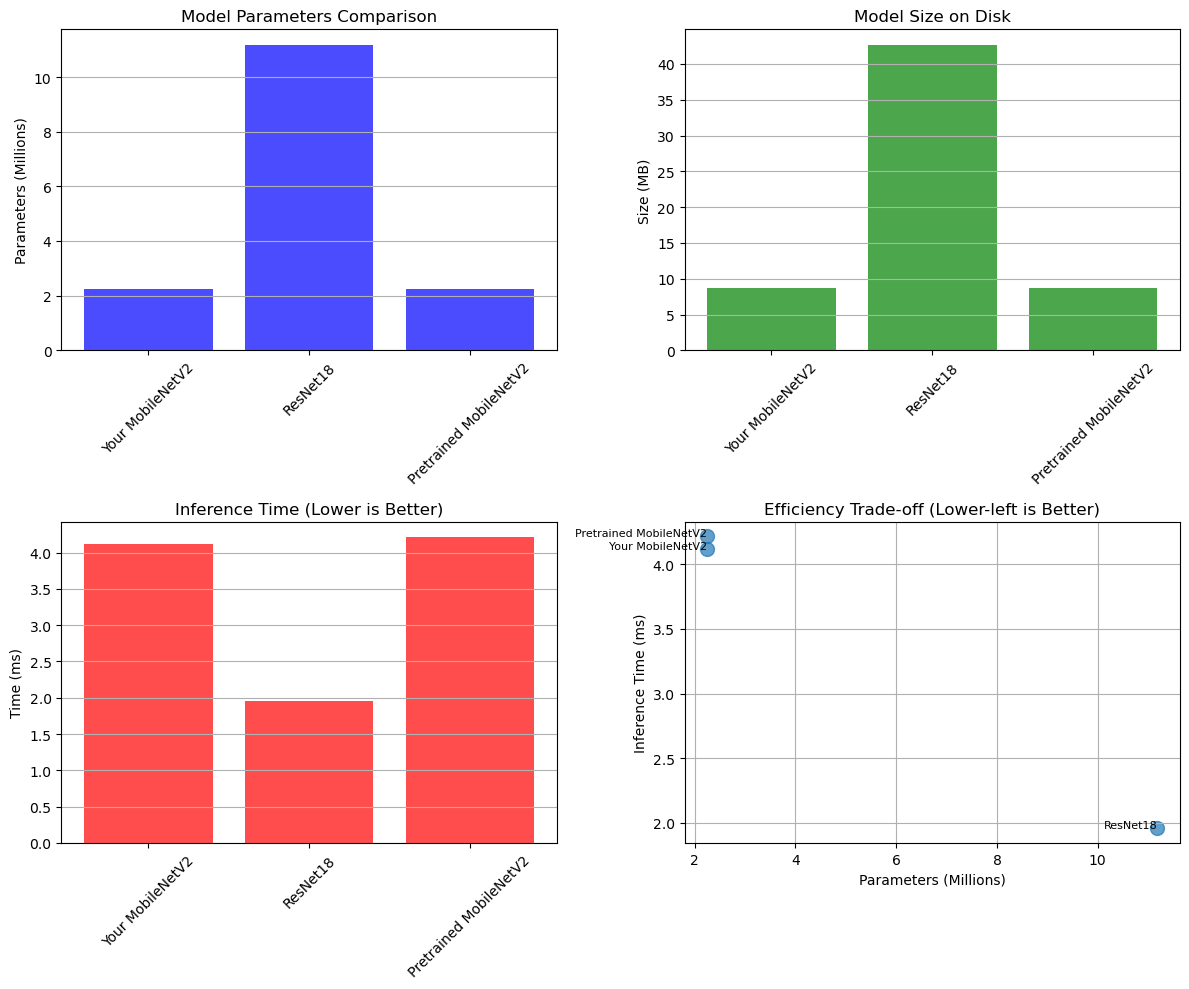


Training Your MobileNetV2


Do you want to train your MobileNetV2? (y/n):  y



Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.49it/s]


Train Loss: 2.4024, Train Acc: 25.07%
Val Loss: 2.1178, Val Acc: 32.44%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.58it/s]


Train Loss: 1.6150, Train Acc: 51.44%
Val Loss: 1.5986, Val Acc: 52.48%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.85it/s]


Train Loss: 1.1524, Train Acc: 65.81%
Val Loss: 1.2041, Val Acc: 63.68%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.49it/s]


Train Loss: 0.6298, Train Acc: 82.20%
Val Loss: 0.6589, Val Acc: 81.74%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.33it/s]


Train Loss: 0.5022, Train Acc: 86.04%
Val Loss: 0.6059, Val Acc: 83.55%


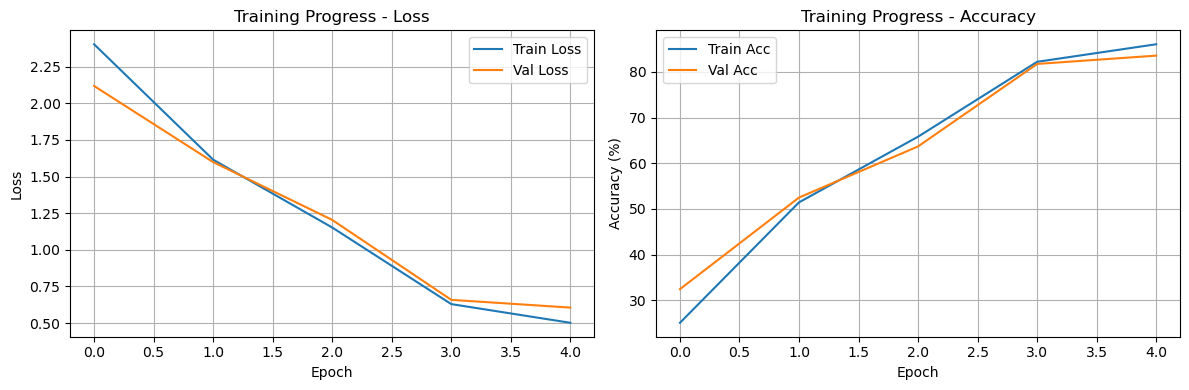


Final Validation Accuracy: 83.55%
✓ Great job! Your model achieves good accuracy while being efficient!

Assignment Complete!

Key Takeaways:
1. Depthwise separable convolutions reduce parameters by ~8-9x
2. Inverted residuals with linear bottlenecks preserve information
3. MobileNetV2 achieves ResNet-level accuracy with 10x fewer parameters
4. Efficient models are crucial for edge deployment (phones, IoT, etc.)


In [25]:
# ============================================================================
# Training Functions (Provided - No TODO)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })

    return running_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

# ============================================================================
# Visualization Functions (Provided - No TODO)
# ============================================================================

def plot_model_comparison(models_dict):
    """Compare efficiency metrics of different models."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    model_names = list(models_dict.keys())
    params_list = []
    size_list = []
    time_list = []

    for name, model in models_dict.items():
        total_params, _ = count_parameters(model)
        params_list.append(total_params / 1e6)  # Convert to millions
        size_list.append(get_model_size_mb(model))
        time_list.append(measure_inference_time(model.to(device)))

    # Plot 1: Parameters
    axes[0, 0].bar(model_names, params_list, color='blue', alpha=0.7)
    axes[0, 0].set_ylabel('Parameters (Millions)')
    axes[0, 0].set_title('Model Parameters Comparison')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, axis='y')

    # Plot 2: Model Size
    axes[0, 1].bar(model_names, size_list, color='green', alpha=0.7)
    axes[0, 1].set_ylabel('Size (MB)')
    axes[0, 1].set_title('Model Size on Disk')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, axis='y')

    # Plot 3: Inference Time
    axes[1, 0].bar(model_names, time_list, color='red', alpha=0.7)
    axes[1, 0].set_ylabel('Time (ms)')
    axes[1, 0].set_title('Inference Time (Lower is Better)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, axis='y')

    # Plot 4: Efficiency Score
    axes[1, 1].scatter(params_list, time_list, s=100, alpha=0.7)
    for i, name in enumerate(model_names):
        axes[1, 1].annotate(name, (params_list[i], time_list[i]),
                           fontsize=8, ha='right')
    axes[1, 1].set_xlabel('Parameters (Millions)')
    axes[1, 1].set_ylabel('Inference Time (ms)')
    axes[1, 1].set_title('Efficiency Trade-off (Lower-left is Better)')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_training_curves(history):
    """Plot training and validation curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curves
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress - Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training Progress - Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ============================================================================
# Main Execution - Test Your Implementation
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("Testing Your Efficient Architecture Implementation")
    print("="*80)

    # Test your implementations
    try:
        # Test DepthwiseSeparableConv
        print("\n1. Testing DepthwiseSeparableConv...")
        dw_conv = DepthwiseSeparableConv(32, 64)
        test_input = torch.randn(1, 32, 56, 56)
        output = dw_conv(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   ✓ DepthwiseSeparableConv working!")
    except Exception as e:
        print(f"   ✗ Error in DepthwiseSeparableConv: {e}")

    try:
        # Test InvertedResidual
        print("\n2. Testing InvertedResidual...")
        inv_res = InvertedResidual(32, 32, stride=1, expand_ratio=6)
        test_input = torch.randn(1, 32, 56, 56)
        output = inv_res(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   ✓ InvertedResidual working!")
    except Exception as e:
        print(f"   ✗ Error in InvertedResidual: {e}")

    try:
        # Test MobileNetV2
        print("\n3. Testing MobileNetV2...")
        mobilenet = MobileNetV2(num_classes=num_classes)
        test_input = torch.randn(1, 3, 224, 224)
        output = mobilenet(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")

        # Analyze model
        total_params, trainable_params = count_parameters(mobilenet)
        model_size = get_model_size_mb(mobilenet)
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: {model_size:.2f} MB")
        print(f"   ✓ MobileNetV2 working!")

    except Exception as e:
        print(f"   ✗ Error in MobileNetV2: {e}")

    # Compare with other models
    print("\n" + "="*80)
    print("Model Comparison")
    print("="*80)

    try:
        # Create models for comparison
        models_to_compare = {
            'Your MobileNetV2': MobileNetV2(num_classes=num_classes),
            'ResNet18': models.resnet18(num_classes=num_classes),
            'Pretrained MobileNetV2': models.mobilenet_v2(weights=None, num_classes=num_classes)
        }

        # Compare models
        for name, model in models_to_compare.items():
            total_params, _ = count_parameters(model)
            size_mb = get_model_size_mb(model)
            print(f"{name:20s}: {total_params/1e6:.2f}M params, {size_mb:.2f} MB")

        # Visualize comparison
        plot_model_comparison(models_to_compare)

    except Exception as e:
        print(f"Error in model comparison: {e}")

    # Train your model (optional - takes time)
    print("\n" + "="*80)
    print("Training Your MobileNetV2")
    print("="*80)

    train_model = input("Do you want to train your MobileNetV2? (y/n): ")

    if train_model.lower() == 'y':
        try:
            model = MobileNetV2(num_classes=num_classes, dropout_prob=0.2)
            model = model.to(device)

            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

            # Training loop
            num_epochs = 5
            history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

            for epoch in range(num_epochs):
                print(f"\nEpoch {epoch+1}/{num_epochs}")
                print("-" * 30)

                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = evaluate(model, val_loader, criterion, device)

                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

                scheduler.step()

            # Plot training curves
            plot_training_curves(history)

            print(f"\nFinal Validation Accuracy: {history['val_acc'][-1]:.2f}%")

            # Success criteria
            if history['val_acc'][-1] > 80:
                print("✓ Great job! Your model achieves good accuracy while being efficient!")
            elif history['val_acc'][-1] > 70:
                print("✓ Good start! Try fine-tuning hyperparameters or training longer.")
            else:
                print("Keep working! Check your implementation and try different settings.")

        except Exception as e:
            print(f"Error during training: {e}")

    print("\n" + "="*80)
    print("Assignment Complete!")
    print("="*80)
    print("\nKey Takeaways:")
    print("1. Depthwise separable convolutions reduce parameters by ~8-9x")
    print("2. Inverted residuals with linear bottlenecks preserve information")
    print("3. MobileNetV2 achieves ResNet-level accuracy with 10x fewer parameters")
    print("4. Efficient models are crucial for edge deployment (phones, IoT, etc.)")
    print("="*80)